In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

In [2]:
duration = 50.
dt = .1
std_dev = 1
vf_size = (15,15)
n_bins = round(duration / float(dt))

S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

In [3]:
size = vf_size # size in pixel of our receptive field
mu = (8, 8) # center of the gabor pathc
sigma = (4,4) #size of the gabor patch
angle = 45 # orientation of the gabor patch
frequency = .085 # spatial frequency of the gabor patch
phase = 0 # pahse of the gabor pathc
#t = (.5 + np.arange(n_bins)) * dt # bin centers


xx, yy = np.meshgrid(1. + np.arange(size[0]),
                         1. + np.arange(size[1]))

# Gaussian envelope
G = np.exp(- np.power(xx - mu[0], 2) / (2. * sigma[0])
            - np.power(yy - mu[1], 2) / (2. * sigma[1]))

# spatial modulation
phi = np.deg2rad(angle)
xxr = xx * np.cos(phi)
yyr = yy * np.sin(phi)
xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
Sn = np.cos(xyr + phase)

K = G * Sn
K /= np.amax(np.abs(K))

In [4]:
noise_variance = 1
offset = 2.

# flatten the matrices in to 1d array for convenience
K_flat = K.ravel()
K_flat = np.hstack((K.flat, offset))

S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))


# 1. linear stage
ks = np.dot(K_flat, S_flat.T)

# 2. nonlinear stage (for a linear model: f -> identity function)
rate = ks

# add Gaussian noise centered around the "true" rate for each bin
rate = rate + np.sqrt(noise_variance) * np.random.randn(n_bins)

In [5]:
#fitting GLM
K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate)
K_hat = K_hat[:-1].reshape(vf_size)

# Exercise 1

The longer the duration of the stimulus, the higher the value of the Pearson correlation. Therefore, The better the correlation between the estimated and true RFs. So for a longer duration of the stimulus, the ability to recover the true RF gets better. However, the difference between the CC of different durations gets very small after 160s. Therefore it is not necesarry to keep increasing the duration as you don't gain more information about the true RF's doing so. 

In [6]:
durations = [5, 10, 20, 40, 80, 160, 320, 640] #take average over 10 realizations
cc = np.zeros(10)
CC = np.zeros(len(durations))

for i in range(len(durations)):
    duration = durations[i]
    n_bins = round(duration / float(dt))
    for j in range(10):
        S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
        S_flat = np.hstack((S.reshape(S.shape[0],S.shape[1]*S.shape[2]), np.ones((n_bins, 1))))
        rate = np.dot(K_flat, S_flat.T) + np.sqrt(noise_variance) * np.random.randn(n_bins) 
        K_hat = (np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate))[:-1].reshape(vf_size)
        cc[j] = np.inner(K_flat[:-1], K_hat.ravel()) / (np.linalg.norm(K_flat[:-1]) * np.linalg.norm(K_hat.ravel()))
    CC[i] = np.mean(cc)

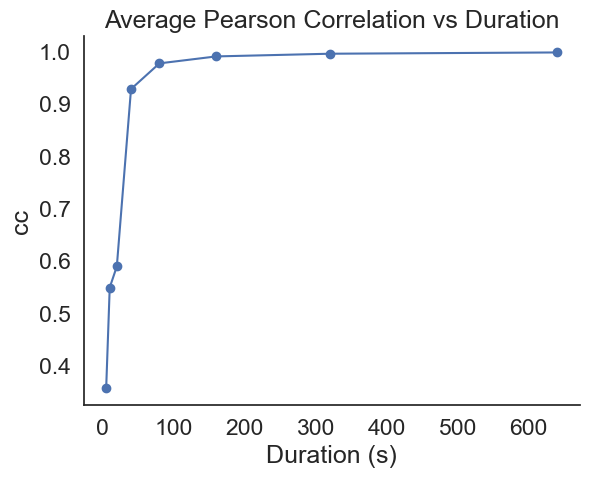

In [7]:
plt.plot(durations, CC, marker='o')
plt.xlabel('Duration (s)')
plt.ylabel('cc')
plt.title('Average Pearson Correlation vs Duration')
plt.show()

# Exercise 2

If the variance over the noise is increased, the value of the pearson relation becomes less. This is because if there is more noise, it is harder to recognize the spikes, and the correlation between the true and estimated RF's is less. You can also see this from the standard deviation between runs for different values of the noise variance. If the value of the noise variance is increased, the standard deviation is higher, meaning there is more difference in the values of the pearson correlation between each run. 

In [8]:
duration = 100
noise_variances = [0, 2, 4, 6, 8, 10] #take average over 10 realizations
cc = np.zeros(10)
CC = np.zeros(len(noise_variances))
std = np.zeros(len(noise_variances))

for i in range(len(noise_variances)):
    noise_variance = noise_variances[i]
    n_bins = round(duration / float(dt))
    for j in range(10):
        S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
        S_flat = np.hstack((S.reshape(S.shape[0],S.shape[1]*S.shape[2]), np.ones((n_bins, 1))))
        rate = np.dot(K_flat, S_flat.T) + np.sqrt(noise_variance) * np.random.randn(n_bins) 
        K_hat = (np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate))[:-1].reshape(vf_size)
        cc[j] = np.inner(K_flat[:-1], K_hat.ravel()) / (np.linalg.norm(K_flat[:-1]) * np.linalg.norm(K_hat.ravel()))
    std[i] = np.std(cc)
    CC[i] = np.mean(cc)

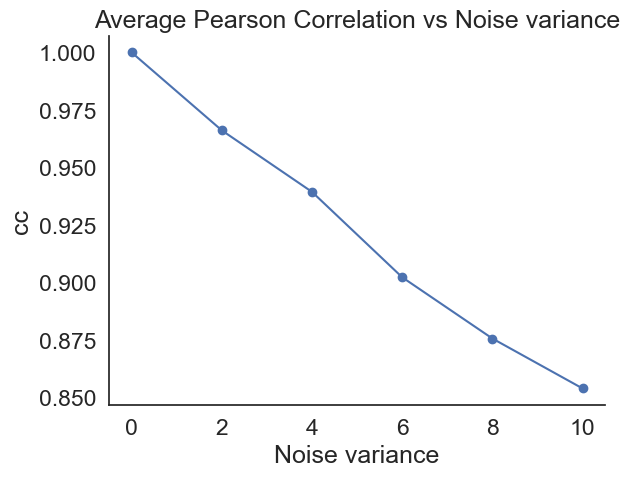

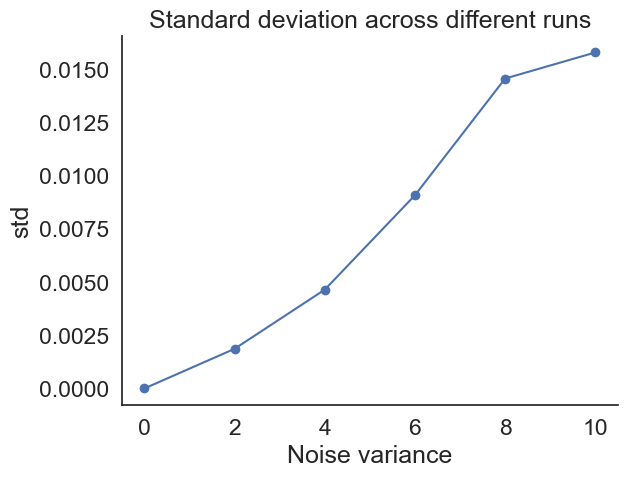

In [9]:
plt.plot(noise_variances, CC, marker='o')
plt.xlabel('Noise variance')
plt.ylabel('cc')
plt.title('Average Pearson Correlation vs Noise variance')
plt.show()

plt.plot(noise_variances, std, marker='o')
plt.xlabel('Noise variance')
plt.ylabel('std')
plt.title('Standard deviation across different runs')
plt.show()

# Exercise 5

In [10]:
duration = 100.
dt = .1
std_dev = 1
vf_size = (15,15)

In [11]:
def generate_inhomogeneous_poisson_spikes(lamda, dt):

    n_bins = lamda.shape[0]
    bins = np.arange(n_bins+1)*dt

    # generate Poisson distributed numbers for all bins with the max. intensity (lamda_max)
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins)

    # throw away numbers depending on the actual intensity ("thinning")
    spike_times = []
    prob = lamda / lamda_max
    for i in range(n_bins):
        
        # number of spikes to keep in this bin
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))

        # generate random spike times in this bin
        ts = bins[i] + np.random.rand(n_s)*dt

        spike_times.extend(ts)

    return np.asarray(spike_times)

In [12]:
from scipy.optimize import minimize

# define functions for minimisation
def cost(k, spike_counts, S,alpha=1):
    #negative loglikelihood function to minimize
    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(spike_counts, ks) + dt * np.sum(lamda)
    
    
def grad(k, spike_counts, S):
    # expression of the gradient of the negative log likelihood (note the sign is flipped accordingly)

    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(S.T, spike_counts - dt*lamda)

# A. 

Here the results are globally the same as for the linear-gaussian model: The longer the duration, the higher the pearson correlation. However, the value of the pearson correlation is lower compared to the linear-gaussian model. This is probably due to the uncertainty of the poisson process that is used here. 

In [13]:
spike_rate = 5 # average firing rate 
durations = [10, 20, 50, 100, 200]
CC = np.zeros(len(durations))
K_est_fig = np.zeros((15,15,len(durations)))
noise_variance = 1

for i in range(len(durations)):
    duration = durations[i]
    n_bins = round(duration / float(dt))
    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))
    ks = np.dot(K_flat, S_flat.T)
    lamda = np.exp(ks)
    expected_rate = np.sum(lamda*dt) / duration
    lamda *= (spike_rate / expected_rate)
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)
    spike_counts = np.histogram(spike_times,bins=np.arange(n_bins+1)*dt)[0]
    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)
    K_est = res.x
    K_est_fig[:,:,i] = K_est[:-1].reshape(15, 15)
    CC[i] = np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))

C:\Users\Myrth\AppData\Local\Temp\ipykernel_16972\2557602062.py:15: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)


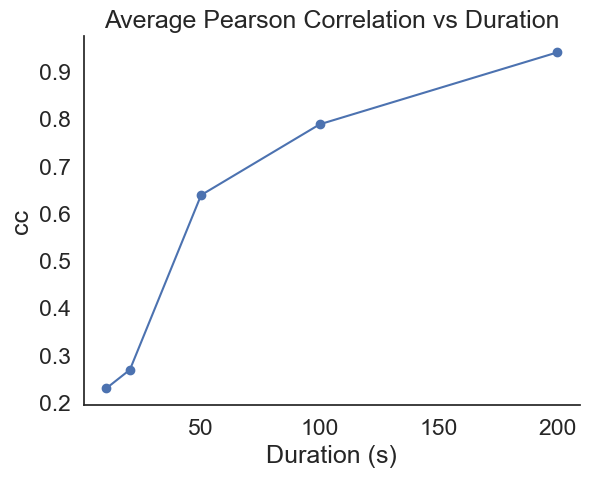

In [14]:
plt.plot(durations, CC, marker='o')
plt.xlabel('Duration (s)')
plt.ylabel('cc')
plt.title('Average Pearson Correlation vs Duration')
plt.show()

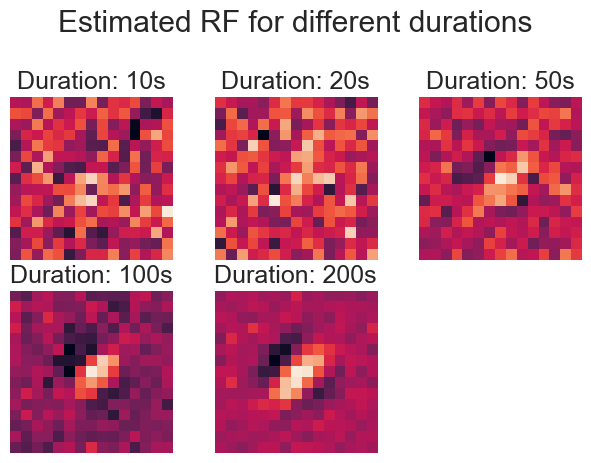

In [15]:
for i in range(len(durations)):
    plt.subplot(2, 3, i+1)
    plt.imshow(K_est_fig[:,:,i])
    plt.title('Duration: {}s'.format(durations[i]))
    plt.axis('off')

plt.suptitle('Estimated RF for different durations')
plt.tight_layout()
plt.show()

# B. 

By varying the spike rates, you notice the pearson relation does not necessarily get better by increasing the spike rates. But overall, it seems to improve if you increase the spike rates. The value of the spike rate determines indirectly how many spikes there will be in a given amount of time. The higher the average firing rate, the more spikes there will be. So there becomes more information than noise, which results in a better estimate and higher pearson correlation.  

In [29]:
spike_rates = np.linspace(1, 20, 5) # average firing rate 
duration = 100
CC = np.zeros(len(spike_rates))
K_est_fig = np.zeros((15,15,len(spike_rates)))

for i in range(len(spike_rates)):
    spike_rate = spike_rates[i]
    n_bins = round(duration / float(dt))
    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))
    ks = np.dot(K_flat, S_flat.T)
    lamda = np.exp(ks)
    expected_rate = np.sum(lamda*dt) / duration
    lamda *= (spike_rate / expected_rate)
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)
    spike_counts = np.histogram(spike_times,bins=np.arange(n_bins+1)*dt)[0]
    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)
    K_est = res.x
    K_est_fig[:,:,i] = K_est[:-1].reshape(15, 15)
    CC[i] = np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))

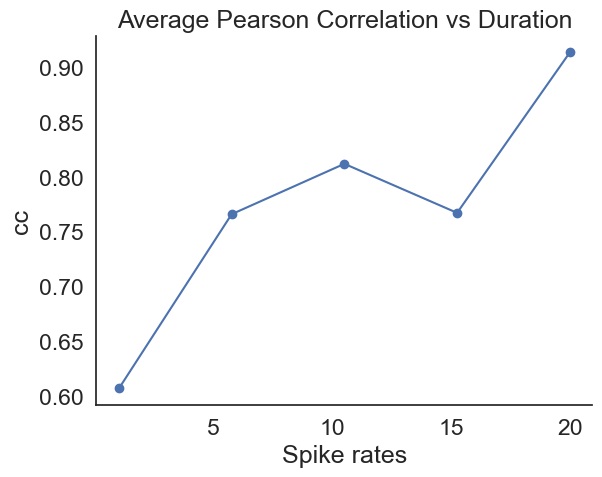

In [30]:
plt.plot(spike_rates, CC, marker='o')
plt.xlabel('Spike rates')
plt.ylabel('cc')
plt.title('Average Pearson Correlation vs Duration')
plt.show()

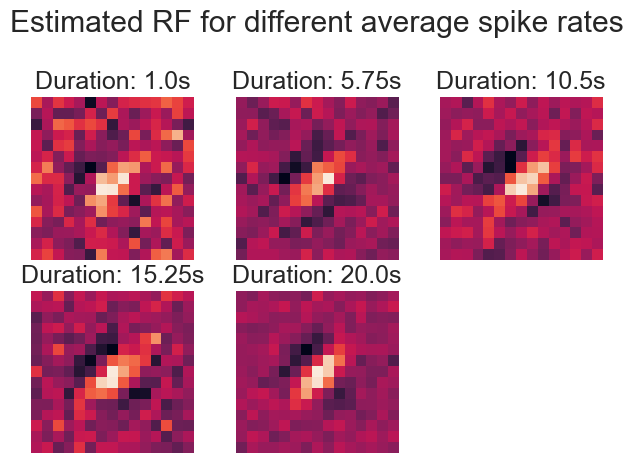

In [31]:
for i in range(len(spike_rates)):
    plt.subplot(2, 3, i+1)
    plt.imshow(K_est_fig[:,:,i])
    plt.title('Duration: {}s'.format(spike_rates[i]))
    plt.axis('off')

plt.suptitle('Estimated RF for different average spike rates')
plt.tight_layout()
plt.show()